In [1]:
import numpy as np
import pandas as pd
import holidays

import matplotlib.pyplot as plt
from matplotlib import gridspec

from tqdm import tqdm
import warnings; warnings.simplefilter('ignore')

# 데이터 가져오기

In [2]:
# 보통주 + 우선주
rawPrice = pd.read_csv('./Data/코스피+코스닥(상폐포함)_수정주가.csv',  low_memory=False, index_col = 'Date')
rawSize = pd.read_csv('./Data/코스피+코스닥(상폐포함)_시가총액.csv',  low_memory=False, index_col = 'Date')
rawNetAsset = pd.read_csv('./Data/코스피+코스닥(상폐포함)_순자산.csv',  low_memory=False, index_col = 'Date')
rawMarket = pd.read_csv('./Data/코스피+코스닥(상폐포함)_상장시장정보.csv', low_memory=False, index_col='Date')
rawIndustry = pd.read_csv('./Data/코스피+코스닥(상폐포함)_거래소업종구분.csv',  low_memory=False, index_col = 'Symbol')

In [3]:
# rawBM = 전년도말 순자산(자본총계 - 무형자산 + 자기주식) / 전년도말 시가총액
rawBM = rawNetAsset / rawSize

In [4]:
rawPrice.index = pd.to_datetime(rawPrice.index)
rawSize.index = pd.to_datetime(rawSize.index)
rawBM.index = pd.to_datetime(rawBM.index)
rawMarket.index = pd.to_datetime(rawMarket.index)

In [5]:
#영업일 기준 데이터로 변환
Price = rawPrice.resample('B').first()

# 한국 공휴일 제외
kr_holidays = holidays.KR()
Price = Price.reindex([day for i, day in enumerate(Price.index) if not day in kr_holidays])

In [6]:
Size = rawSize.reindex(Price.index)
BM = rawBM.reindex(Price.index)
Market = rawMarket.reindex(Price.index)

In [7]:
# 보통주 제외 모두 제거(우선주, 스팩) + 금융업 제외
ForManufac = rawIndustry.iloc[[i for i, name in enumerate(rawIndustry['거래소 업종구분'].fillna('x')) if '제조업' in name]]
ManufacCode = list(ForManufac.index)

In [8]:
Price = Price[ManufacCode]
Size = Size[ManufacCode]
BM = BM[ManufacCode]
Market = Market[ManufacCode]

In [9]:
# 중국 기업 제외
DropCHI = [sym for sym in Price.columns if sym[:2] != 'A9']
Price = Price[DropCHI]
Size = Size[DropCHI]
BM = BM[DropCHI]
Market = Market[DropCHI]

In [10]:
Return = (Price.diff() / Price.shift(1))*100

In [11]:
# 영업일 기준 모든 연도의 6월말 날짜 리스트 생성(리밸런싱을 7월에 하기 때문)
dates = Return.index
june = []
for year in dates.year.unique():
    june_date = dates[(dates.year == year) & (dates.month == 6)][-1]
    june.append(june_date)

# 전년도 12월 말 기준 BM ratio를 사용하여 리밸런싱 시점의 포트폴리오 종목 구성
dec = []
for year in dates.year.unique():
    dec_date = dates[(dates.year == year) & (dates.month == 12)][-1]
    dec.append(dec_date)
    
# 1990년 6월 제외(Book to Market 데이터가 1989년 12월에 없기 때문에)
june = june[1:]

# 2021년 6월 ~ 2021년 12월까지 데이터도 indexing할 수 있도록, june 마지막에 원소를 추가함
june.append(pd.to_datetime('2022-06-30'))

# 전일 종가를 기준으로 포트폴리오 weight를 계산하므로 shift
Size_shift = Size.shift(1)

# 함수생성

In [12]:
def get_Threshold(value):
    
    thres_dic = {
        'bpL' : np.quantile(value, 0.2),
        'bpML' : np.quantile(value, 0.4),
        'bpM' : np.quantile(value, 0.6),
        'bpMH' : np.quantile(value, 0.8),
        'bpH' : np.quantile(value, 1.0)
    }
    return thres_dic

In [13]:
#Quintile portfolio별 편입종목의 인덱스를 반환하는 함수
def get_PortIndex(value, value_threshold):

    bpL, bpML, bpM, bpMH, bpH = list(value_threshold.values())
    
    Index_dic = {
        'Low' : list(value[(value <= bpL)].index),
        'MediumLow' : list(value[(bpL < value) & (value <= bpML)].index),
        'Medium' : list(value[(bpML < value) & (value <= bpM)].index),
        'MediumHigh' : list(value[(bpM < value) & (value <= bpMH)].index),
        'High' : list(value[(bpMH < value) & (value <= bpH)].index)
    }
    
    return Index_dic

In [14]:
#Quintile portfolio들의 가치가중 수익률을 반환하는 함수
def get_return(ReturnDate, size, Index_dic):
    return_ls = []
    
    for PortIndex_ls in Index_dic.values():
        # 포트폴리오 구성종목 추출
        weight_size = size.reindex(PortIndex_ls)
        
        # value-weight 계산
        weight_size /= np.sum(weight_size)
        
        # value-weighted return 계산
        ret = np.sum(ReturnDate*weight_size)
        
        # 수익률 기록
        return_ls.append(ret)
        
    return return_ls

# Portfolio Return 계산

In [15]:
portfolio_return = pd.DataFrame(columns=['Low','MediumLow', 'Medium', 'MediumHigh', 'High'])
#매년 7월초 리밸런싱
for pre_june, aft_june, bef_dec in tqdm(zip(june[:-1], june[1:], dec)):
    
    june_market = Market.loc[pre_june]
    june_kospi_symbol = list(june_market[june_market == 'KOSPI'].index)
    
    # t년 6월말에 KOSPI에 소속된 기업의 t-1년 12월말 B/M을 가져옴
    kospi_value = BM.loc[bef_dec, june_kospi_symbol].dropna()
    thres_value = get_Threshold(kospi_value)
    
    # t-1년 12월말 B/M을 기준으로 portfolio 구성종목을 identify함
    pre_dec_Value = BM.loc[bef_dec].dropna()
    
    PortIndex_dic = get_PortIndex(pre_dec_Value, thres_value)
    
    intervals = (pre_june < dates) & (dates <= aft_june)
    intervals_return = Return.loc[intervals]
    intervals_size = Size_shift.loc[intervals]
    
    for d in intervals_return.index:
        return_d = intervals_return.loc[d].dropna()
        size_d = intervals_size.loc[d].dropna()
            
        # Low MediumLow Medium MediumHigh High 수익률을 순서대로 계산
        port_return = get_return(return_d, size_d, PortIndex_dic)
            
        # 수익률 기록
        portfolio_return.loc[d] = port_return

31it [02:15,  4.36s/it]


In [16]:
portfolio_return.iloc[0,:] = 0 # 초기시점 수익률 0으로 초기화
portfolio_value = (1+portfolio_return/100).cumprod()*100 # 투자원금 100

portfolio_MAXp = portfolio_value.cummax()
portfolio_DDp = (portfolio_value/portfolio_MAXp - 1)*100  # 단위: %

In [17]:
# High - Low (Long-Short 전략)
flag_winnerBuy = 1 # High buy 포지션

# 1 이면 Low portfolio sell, 0 이면 nothing
flag_loserSell = 1 # Low sell 포지션

# High Minus Low(HML)
Rp = flag_winnerBuy*portfolio_return.iloc[:, -1] - flag_loserSell*portfolio_return.iloc[:, 0]
Vp = (1+Rp/100).cumprod()*100
    
# Portfolio DD
MAXp = Vp.cummax()
DDp = (Vp/MAXp - 1) * 100  # 단위: %

In [18]:
# 그래프 그려주는 함수 MDD 포함
def get_plot(ValueData, DDpData):
    fig = plt.figure(figsize = (10, 7))    # figsize = (가로길이, 세로길이)
    gs = gridspec.GridSpec(nrows = 2,      # row 개수
                           ncols = 1,      # col 개수
                           height_ratios=[8, 3],
                           width_ratios=[5])    # subplot의 크기를 서로 다르게 설정
    for i in range(len(ValueData.columns)):
        ax0 = plt.subplot(gs[0])
        ax0.plot(ValueData.index, ValueData[ValueData.columns[i]], label = str(ValueData.columns[i]))
        ax0.set_title('<Value:  Value Factor>')
        ax0.grid(True)
        ax0.legend()
    for j in range(len(DDpData.columns)):
        ax1 = plt.subplot(gs[1])
        ax1.plot(DDpData.index, DDpData[DDpData.columns[j]], label = str(DDpData.columns[j]))
        ax1.set_title('<Draw-Down: Value Factor>')
        ax1.grid(True)
        ax1.legend()
    plt.show()

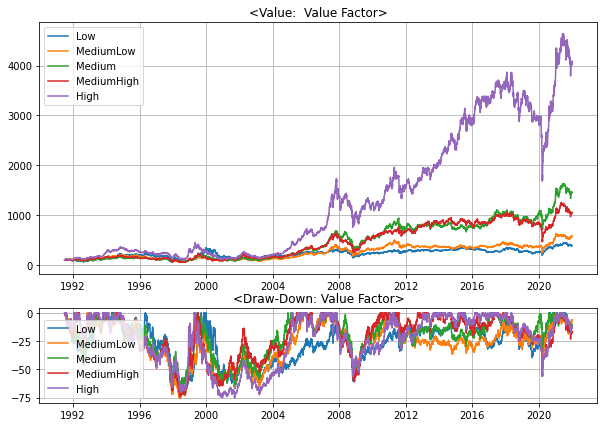

In [19]:
# Value Path
get_plot(portfolio_value, portfolio_DDp)

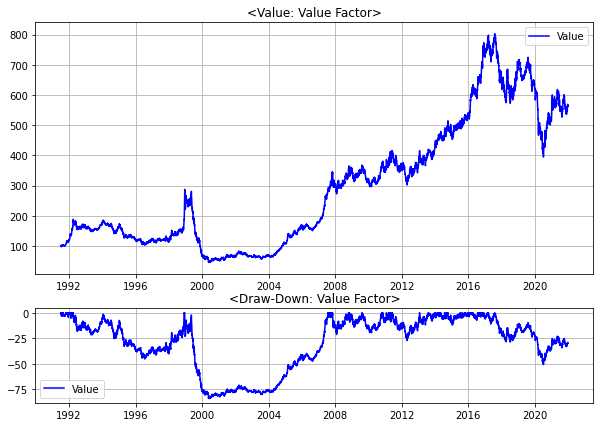

In [20]:
# Value와 MDD 그리기    
fig = plt.figure(figsize = (10, 7))    # figsize = (가로길이, 세로길이)
gs = gridspec.GridSpec(nrows = 2,      # row 개수
                       ncols = 1,      # col 개수
                       height_ratios=[8, 3], # subplot의 크기를 서로 다르게 설정
                       width_ratios=[5])

ax0 = plt.subplot(gs[0])
ax0.plot(Vp.index, Vp, label = 'Value', c = 'b')
ax0.set_title('<Value: Value Factor>')
ax0.grid(True)
ax0.legend()

ax1 = plt.subplot(gs[1])
ax1.plot(DDp.index, DDp, label = 'Value', c = 'b')
ax1.set_title('<Draw-Down: Value Factor>')
ax1.grid(True)
ax1.legend()

plt.show()

In [27]:
FFmodel = pd.read_csv('./Data/Fama_French(2x3)_portfolio.csv', index_col = 'Symbol')
FFmodel.index = pd.to_datetime(FFmodel.index)

In [29]:
FFmodel['S'] = FFmodel[['SH', 'SN', 'SL']].mean(axis=1)
FFmodel['B'] = FFmodel[['BH', 'BN', 'BL']].mean(axis=1)
FFmodel['H'] = FFmodel[['SH', 'BH']].mean(axis=1)
FFmodel['L'] = FFmodel[['SL', 'BL']].mean(axis=1)

FFmodel['SMB'] = FFmodel['S'] - FFmodel['B']
FFmodel['HML'] = FFmodel['H'] - FFmodel['L']

In [30]:
FFmodel = FFmodel[pd.to_datetime('1991-07-01'):]

In [31]:
FFmodel.iloc[0,:] = 0 # 초기시점 수익률 0으로 초기화
FFmodel_value = (1+FFmodel/100).cumprod()*100 # 투자원금 100

FFmodel_MAXp = FFmodel_value.cummax()
FFmodel_DDp = (FFmodel_value/FFmodel_MAXp - 1)*100  # 단위: %

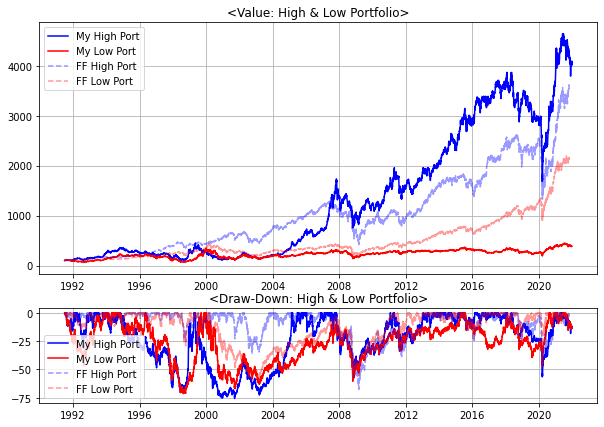

In [41]:
# Value와 MDD 그리기    
fig = plt.figure(figsize = (10, 7))    # figsize = (가로길이, 세로길이)
gs = gridspec.GridSpec(nrows = 2,      # row 개수
                       ncols = 1,      # col 개수
                       height_ratios=[8, 3], # subplot의 크기를 서로 다르게 설정
                       width_ratios=[5])

ax0 = plt.subplot(gs[0])
ax0.plot(portfolio_value.index, portfolio_value['High'], label = 'My High Port', c = 'b')
ax0.plot(portfolio_value.index, portfolio_value['Low'], label = 'My Low Port', c = 'r')
ax0.plot(FFmodel_value.index, FFmodel_value['H'], label = 'FF High Port', c = 'b', linestyle = '--', alpha = 0.4)
ax0.plot(FFmodel_value.index, FFmodel_value['L'], label = 'FF Low Port', c = 'r', linestyle = '--', alpha = 0.4)
ax0.set_title('<Value: High & Low Portfolio>')
ax0.grid(True)
ax0.legend()

ax1 = plt.subplot(gs[1])
ax1.plot(portfolio_DDp.index, portfolio_DDp['High'], label = 'My High Port', c = 'b')
ax1.plot(portfolio_DDp.index, portfolio_DDp['Low'], label = 'My Low Port', c = 'r')
ax1.plot(FFmodel_DDp.index, FFmodel_DDp['H'], label = 'FF High Port', c = 'b', linestyle = '--', alpha = 0.4)
ax1.plot(FFmodel_DDp.index, FFmodel_DDp['L'], label = 'FF Low Port', c = 'r', linestyle = '--', alpha = 0.4)
ax1.set_title('<Draw-Down: High & Low Portfolio>')
ax1.grid(True)
ax1.legend()

plt.show()

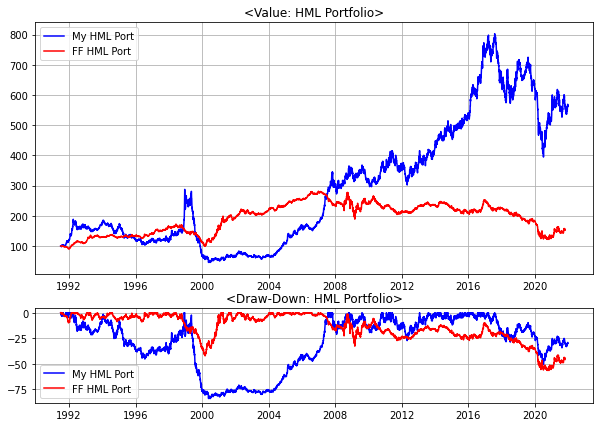

In [43]:
# Value와 MDD 그리기    
fig = plt.figure(figsize = (10, 7))    # figsize = (가로길이, 세로길이)
gs = gridspec.GridSpec(nrows = 2,      # row 개수
                       ncols = 1,      # col 개수
                       height_ratios=[8, 3], # subplot의 크기를 서로 다르게 설정
                       width_ratios=[5])

ax0 = plt.subplot(gs[0])
ax0.plot(Vp.index, Vp, label = 'My HML Port', c = 'b')
ax0.plot(FFmodel_value.index, FFmodel_value['HML'], label = 'FF HML Port', c = 'r')
ax0.set_title('<Value: HML Portfolio>')
ax0.grid(True)
ax0.legend()

ax1 = plt.subplot(gs[1])
ax1.plot(DDp.index, DDp, label = 'My HML Port', c = 'b')
ax1.plot(FFmodel_DDp.index, FFmodel_DDp['HML'], label = 'FF HML Port', c = 'r')
ax1.set_title('<Draw-Down: HML Portfolio>')
ax1.grid(True)
ax1.legend()

plt.show()